In [1]:
%matplotlib inline
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pickle
import gzip
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestClassifier
from helpers import plotcfg
from helpers import myfunc
from helpers import classic_algorithms
from helpers import preprocessing
from scipy import signal


In [2]:
X, y, d = pickle.load(gzip.open('../data/artificial.pickle', 'rb'), encoding='latin1')

## Getting rid of the baseline and extracting new features

The different intensities of the continuum in the spectra, which may come from different interferences in the samples, hinder the performance of the ML models if they are not corrected. Furthermore, we could make use of some of the signal processing toolkit that could give the machine learning model novel insights about the spectrum. Therefore, I decided to use a **wavelet transform** (and the Ricker operator) which will both flat out the different baseline heights, and will generate new data for the model.


In [4]:
sig = X[0]
maxwidth = 5 
widths = np.arange(1, maxwidth)
cwtmatr = signal.cwt(sig, signal.ricker, widths)

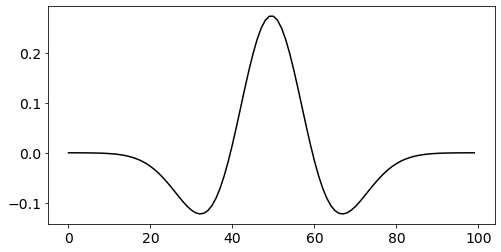

In [19]:
plt.figure(figsize=(8,4))
a = 10
points = 100
vec2 = signal.ricker(points, a)
plt.plot(vec2, color='black')
plt.show()

Say hello to my magical Mexican hat.

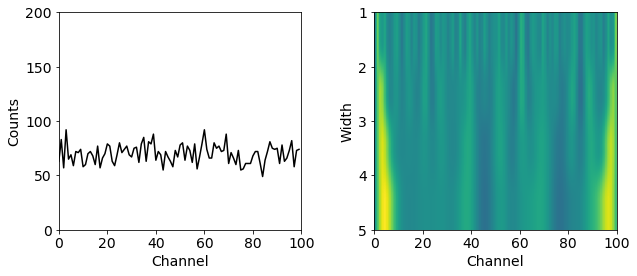

In [16]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(sig,  color="black")
plt.xlim(0,100)
plt.ylim(0,200)
plt.ylabel('Counts')
plt.xlabel('Channel')

plt.subplot(1,2,2)
plt.imshow(cwtmatr, extent=[0, 100, maxwidth, 1], cmap='viridis', aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.yticks(np.arange(1,6),np.arange(1,6))
plt.ylabel('Width')
plt.xlabel('Channel')


plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.show()

Example of the original signal (left), and the same signal after the wavelet transform (right).

## Dimensionality reduction

The dimensionality reduction of the model was made through the selection of the most relevant input parameters, discarding the redundant parameters that do not contribute to the performance of the AI model. For this task, a random forest was used.

In [7]:
forest = RandomForestClassifier()
x_cwt = preprocessing.Cwt().transform(X)
forest.fit(x_cwt, y)
importances = forest.feature_importances_

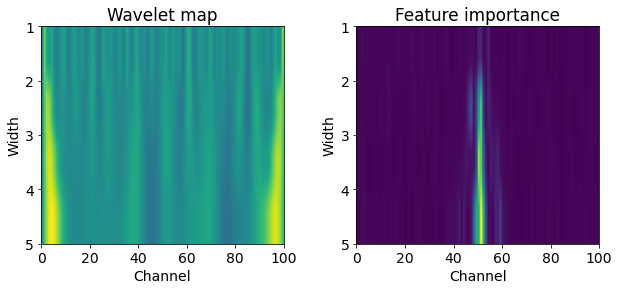

In [13]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(cwtmatr, extent=[0, 100, maxwidth, 1], cmap='viridis', aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.yticks(np.arange(1,6),np.arange(1,6))
plt.ylabel('Width')
plt.xlabel('Channel')
plt.title('Wavelet map')

plt.subplot(1,2,2)
plt.imshow(importances.reshape(cwtmatr.shape), extent=[0, 100, maxwidth, 1], cmap='viridis', aspect='auto',
           vmax=importances.max(), vmin=importances.min())

plt.ylabel('Width')
plt.xlabel('Channel')
plt.title('Feature importance')

plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.show()

After mapping out which parts of the wavelet map (left) carries the most relevant informat (right), now it's time to implement the machine learning model and see how it performs.